In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import preprocess_input
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_SIZE = (200, 200)

In [8]:
data_dir = '/content/drive/MyDrive/Dataset/Body Shape Dataset'

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=4
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=4
)

Found 28 images belonging to 3 classes.
Found 5 images belonging to 3 classes.


# CNN

In [9]:
def create_models(num_classes, input_shape=(200, 200, 3), embedding_dim=128):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    # Dropout to prevent overfitting
    x = layers.Dropout(0.5)(x)

    # Embedding layer
    embedding = layers.Dense(embedding_dim, name='embedding')(x)

    # Classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(embedding)

    # Create models
    full_model = models.Model(inputs=inputs, outputs=outputs, name='body_shape_classifier')
    embedding_model = models.Model(inputs=inputs, outputs=embedding, name='body_shape_embedding')

    return full_model, embedding_model

In [10]:
num_classes = len(train_generator.class_indices)

classifier_model, embedding_model = create_models(num_classes=num_classes)

classifier_model.summary()
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "body_shape_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,699 (1.61 MB)

 Trainable params: 421,699 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = classifier_model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2857 - loss: 1.1259 - val_accuracy: 0.4000 - val_loss: 1.0563
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4643 - loss: 1.0445 - val_accuracy: 0.4000 - val_loss: 1.0221
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4643 - loss: 1.1086 - val_accuracy: 0.4000 - val_loss: 1.0083
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.0493 - val_accuracy: 0.6000 - val_loss: 1.0356
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3214 - loss: 1.0537 - val_accuracy: 0.4000 - val_loss: 1.0403
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 1.0492 - val_accuracy: 0.4000 - val_loss: 1.0086
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3571 - loss: 1.0899 - val_accuracy: 0.6000 - val_loss: 0.9720
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4643 - loss: 1.0026 - val_accuracy: 0.6000 - val_loss: 0.9695
Epoch 9/50
1/1 ━━━━━━━━━━━━

In [12]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = classifier_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6000 - loss: 0.9878
Validation Loss: 0.9878
Validation Accuracy: 0.6000


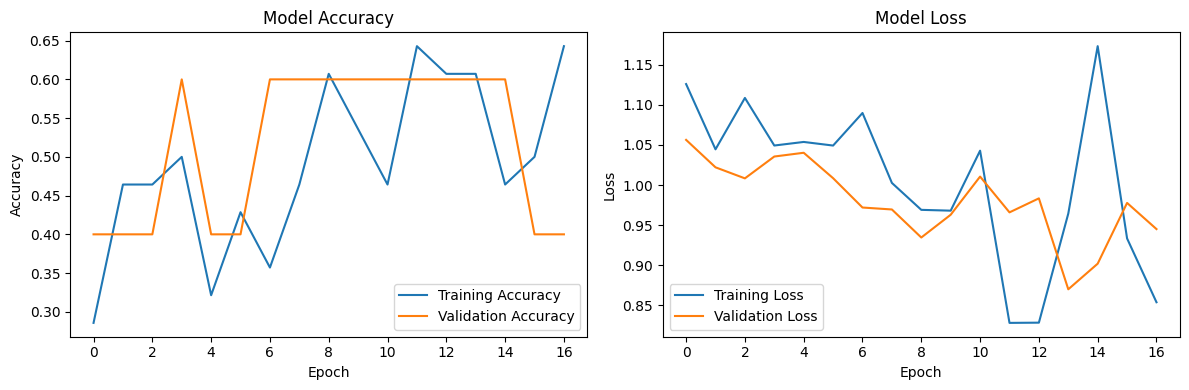

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
classes = list(train_generator.class_indices.keys())

def predict_body_shape(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.
    predicts = classifier_model.predict(img_array)
    predicted_class = classes[np.argmax(predicts)]
    return predicted_class

In [15]:
predict_body_shape('/content/drive/MyDrive/Dataset/Body Shape Dataset/Mesomorph/729632c5cb4f7540db272d5873f0bf0e.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


'Mesomorph'

In [16]:
# Save the models
classifier_model.save('body_shape_cnn_model.h5')

print("Models saved successfully.")

Models saved successfully.


# VGG19

In [3]:
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3

In [19]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
for layer in base_model.layers[:19]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
embedding_model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
    # callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.4286 - loss: 1.0929 - val_accuracy: 0.4000 - val_loss: 2.0044
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.4286 - loss: 1.5293 - val_accuracy: 0.6000 - val_loss: 1.1065
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.5714 - loss: 1.0398 - val_accuracy: 0.6000 - val_loss: 1.0070
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.6429 - loss: 1.0020 - val_accuracy: 0.6000 - val_loss: 0.9835
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.7143 - loss: 0.9138 - val_accuracy: 0.6000 - val_loss: 1.1012
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.6071 - loss: 0.9144 - val_accuracy: 0.6000 - val_loss: 1.0379
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.4286 - loss: 0.9221 - val_accuracy: 0.4000 - val_loss: 1.2497
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.5714 - loss: 0.9033 - val_accuracy: 0.4000 - val_loss: 1.3187
Epoch 9/50


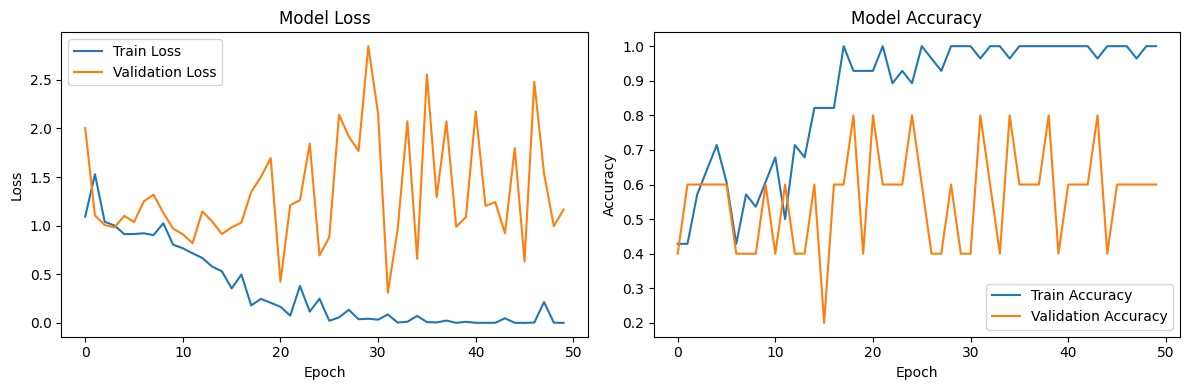

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Get predictions on the validation set
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [23]:
# Generate classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

   Ectomorph       0.00      0.00      0.00         1
   Endomorph       0.50      0.50      0.50         2
   Mesomorph       0.33      0.50      0.40         2

    accuracy                           0.40         5
   macro avg       0.28      0.33      0.30         5
weighted avg       0.33      0.40      0.36         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


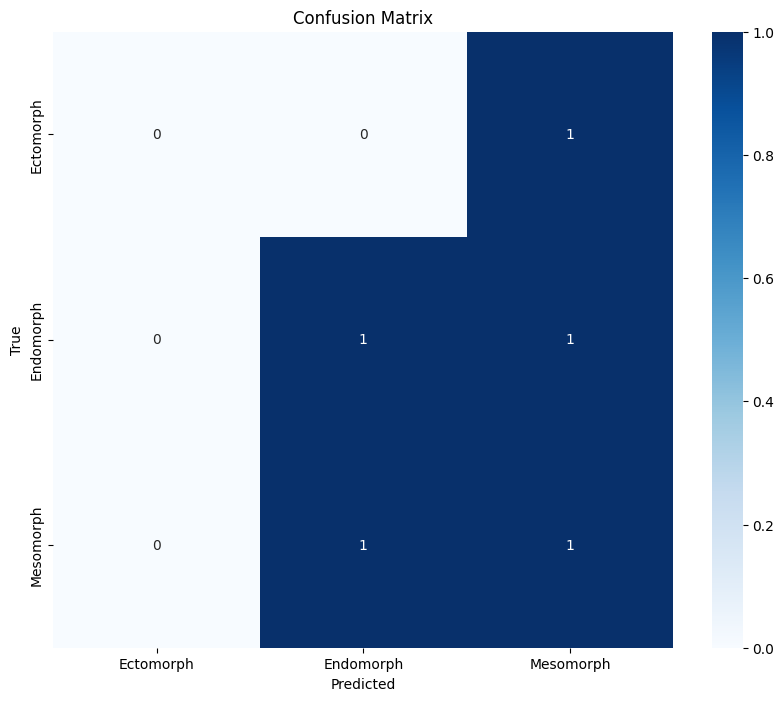

In [24]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
classes = list(train_generator.class_indices.keys())

def predict_dress_style(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.

    predicts = model.predict(img_array)

    top_3_indices = np.argsort(predicts[0])[::-1][:3]
    top_3_classes = [classes[i] for i in top_3_indices]
    top_3_probs = [predicts[0][i] for i in top_3_indices]

    return list(zip(top_3_classes, top_3_probs))

In [42]:
input_image_path = "/content/drive/MyDrive/Dataset/Body Shape Dataset/Mesomorph/6411542b3665e91310fc65acbcf453c0.jpg"
predict_dress_style(input_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


[('Mesomorph', 0.9999938),
 ('Endomorph', 5.893195e-06),
 ('Ectomorph', 2.57887e-07)]

In [27]:
# Save the final model
model.save('body_type_model.h5')

print('Training process has finished. Saved trained model.')

Training process has finished. Saved trained model.


In [ ]:
def extract_features(model, data_dir):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    features = model.predict(generator)

    return features, generator.classes, generator.class_indices

In [ ]:
features, labels, class_indices = extract_features(embedding_model, data_dir)

In [ ]:
def save_embeddings(features, labels, class_indices, file_path='fine_tuned_embeddings.pickle'):
    data = {
        'features': features,
        'labels': labels,
        'class_indices': class_indices
    }

    with open(file_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
save_embeddings(features, labels, class_indices)